In [1]:
import numpy as np
import pandas as pd

In [2]:
import glob
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [3]:
import sys
sys.path.insert(0, '/home/ubuntu/seongyoon/PI/Impedance')

In [4]:
cellname = '25C01'
# Cell name list
# 25C01
# 25C02
# 25C03
# 25C04
# 25C05
# 25C06
# 25C07
# 25C08
# 35C01
# 35C02
# 45C01
# 45C02

datapath = './data/Cavendish/'

filename = f'{datapath}EIS_state_V_{cellname}.txt'

data = pd.read_csv(filename, delimiter='\t')
data.columns = data.columns.str.strip()

In [5]:
cellname = '25C01'
datapath = '../examples/data/Cavendish/'
filename = f'{datapath}EIS_state_V_{cellname}.txt'

data = pd.read_csv(filename, delimiter='\t')
data.columns = data.columns.str.strip()

cycle = 261
data_real = data[data['cycle number'] == cycle]['Re(Z)/Ohm'].values
data_imag = data[data['cycle number'] == cycle]['-Im(Z)/Ohm'].values
data_freq = data[data['cycle number'] == cycle]['freq/Hz'].values

impedance = np.concatenate([data_real, data_imag])

In [6]:
from impedancecircuit.models.elements import R, C, L, CPE, p

In [24]:
custom_initial_guess = np.zeros(7)
custom_initial_guess[1] = np.log(min(data_real))
custom_initial_guess[0] = np.log(abs(data_imag[np.argmin(data_real)])/(2*np.pi*data_freq[np.argmin(data_real)]))

In [25]:
sigmoid_idx = np.zeros(len(custom_initial_guess), dtype=int)
sigmoid_idx[[4, 6]] = 1

def sigmoid(x):
    return 1./(1.+np.exp(-x))

def circuit_func(frequency, *parameters):
    parameters = np.array(parameters)
    parameters = np.where(sigmoid_idx,
                            sigmoid(parameters),
                            np.exp(parameters))
    # parameters[sigmoid_idx] = sigmoid(parameters[sigmoid_idx])
    # parameters[softplus_idx] = softplus(parameters[softplus_idx])
    # Temporarily fixed circuit
    z = L([parameters[0],], frequency) + \
        R([parameters[1],], frequency) + \
        p([R([parameters[2],], frequency),
            CPE([parameters[3], parameters[4]], frequency)]) + \
        CPE([parameters[5], parameters[6]], frequency)
    z_real = np.real(z)
    z_imag = np.imag(z)
    return np.hstack([z_real, z_imag])

In [26]:
parameters, _ = curve_fit(circuit_func, data_freq, impedance,
                          p0=custom_initial_guess, method='lm', maxfev=10000)

In [29]:
np.where(sigmoid_idx,sigmoid(parameters),np.exp(parameters))

array([5.39662340e-07, 4.99333443e-01, 1.04245172e+00, 1.05257207e-01,
       5.06410141e-01, 2.58046073e+01, 2.78942321e-06])

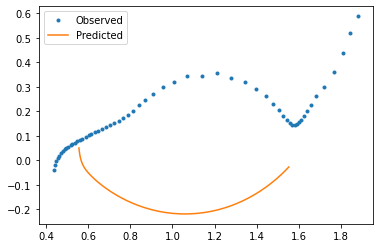

In [27]:
impedance_pred = circuit_func(data_freq, *parameters)

plt.plot(data_real, data_imag, '.', label='Observed')
plt.plot(impedance_pred[:len(impedance_pred)//2], impedance_pred[len(impedance_pred)//2:], '-', label='Predicted')
plt.legend()
plt.show()